In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Configuration
raw_dir = '../datasets/kaggle_m5_walmart_daily_raw'
output_file = '../datasets/m5_walmart_hobbies_daily.csv'

# Files
calendar_file = f'{raw_dir}/calendar.csv'
sales_file = f'{raw_dir}/sales_train_validation.csv'

In [48]:
# 1. Load Calendar Data
# We need this to map 'd_1', 'd_2'... to actual dates and get holiday info
try:
    df_cal = pd.read_csv(calendar_file)
    print("Calendar loaded.")
    print(df_cal.head())
except Exception as e:
    print(f"Error loading calendar: {e}")

Calendar loaded.
         date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1  


In [49]:
# 2. Load Sales Data and Sample
# We need to filter for 'HOBBIES' category and sample 5 unique items.
try:
    df_sales = pd.read_csv(sales_file)
    print("Sales data loaded.")
    
    # Filter for HOBBIES category
    df_hobbies = df_sales[df_sales['cat_id'] == 'HOBBIES'].copy()
    print(f"Filtered HOBBIES shape (all stores): {df_hobbies.shape}")

    # Sample 5 unique items (we take the first store occurrence for each item to avoid duplicates across stores)
    # Alternatively, we could just sample 5 rows from df_hobbies, but let's ensure unique item_ids as requested.
    df_hobbies_unique = df_hobbies.drop_duplicates(subset=['item_id'])
    
    # Sample 5 items
    df_sample = df_hobbies_unique.sample(n=5, random_state=42) # random_state for reproducibility
    print(f"Sampled 5 items shape: {df_sample.shape}")
    print("Selected items:", df_sample['item_id'].tolist())
    
except Exception as e:
    print(f"Error loading sales: {e}")

Sales data loaded.
Filtered HOBBIES shape (all stores): (5650, 1919)
Sampled 5 items shape: (5, 1919)
Selected items: ['HOBBIES_2_123', 'HOBBIES_2_108', 'HOBBIES_1_242', 'HOBBIES_2_109', 'HOBBIES_2_071']


In [50]:
# 3. Transform to Long Format (Melt)
# We want to keep individual time series for the 5 selected items.

# Identify day columns (d_1, d_2, ...)
d_cols = [c for c in df_sample.columns if 'd_' in c]

# We keep item_id as the unique identifier (since we selected unique items)
# We can also keep store_id/state_id if needed, but item_id is the requested unique_id.
id_vars = ['item_id'] 

# Melt
df_melted = pd.melt(df_sample, id_vars=id_vars, value_vars=d_cols, var_name='d', value_name='sales')

print("Melted DataFrame:")
print(df_melted.head())
print(f"Melted shape: {df_melted.shape}")

Melted DataFrame:
         item_id    d  sales
0  HOBBIES_2_123  d_1      0
1  HOBBIES_2_108  d_1      0
2  HOBBIES_1_242  d_1      7
3  HOBBIES_2_109  d_1      0
4  HOBBIES_2_071  d_1      0
Melted shape: (9565, 3)


In [51]:
# 4. Merge with Calendar and Standardize
# We need to join df_melted['d'] with df_cal['d']

# Select relevant calendar columns
cal_cols = ['date', 'd', 'event_name_1', 'event_type_1', 'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI']
df_cal_subset = df_cal[cal_cols].copy()

# Merge
df_final = pd.merge(df_melted, df_cal_subset, on='d', how='left')

# Rename columns to standardized names
df_final.rename(columns={
    'date': 'timestamp',
    'sales': 'sales_count',
    'item_id': 'unique_id'
}, inplace=True)

# Convert timestamp to datetime
df_final['timestamp'] = pd.to_datetime(df_final['timestamp'])

# Fill NaN events with 'NoEvent'
df_final['event_name_1'] = df_final['event_name_1'].fillna('NoEvent')
df_final['event_type_1'] = df_final['event_type_1'].fillna('NoEvent')

# Create a combined SNAP index
df_final['snap_total'] = df_final['snap_CA'] + df_final['snap_TX'] + df_final['snap_WI']

# Drop the 'd' column
df_final.drop(columns=['d'], inplace=True)

# Reorder columns: timestamp, unique_id, sales_count, then the rest
cols = ['timestamp', 'unique_id', 'sales_count'] + [c for c in df_final.columns if c not in ['timestamp', 'unique_id', 'sales_count']]
df_final = df_final[cols]

# Sort by timestamp and unique_id
df_final.sort_values(by=['timestamp', 'unique_id'], inplace=True)

# Handling Index:
# Since we have multiple time series (Panel Data), a simple timestamp index would contain duplicates.
# We can use a MultiIndex (timestamp, unique_id) which uniquely identifies each row.
df_final.set_index(['timestamp', 'unique_id'], inplace=True)

print("Final Dataset Head:")
print(df_final.head())
print(f"Final shape: {df_final.shape}")

Final Dataset Head:
                          sales_count event_name_1 event_type_1  wday  month  \
timestamp  unique_id                                                           
2011-01-29 HOBBIES_1_242            7      NoEvent      NoEvent     1      1   
           HOBBIES_2_071            0      NoEvent      NoEvent     1      1   
           HOBBIES_2_108            0      NoEvent      NoEvent     1      1   
           HOBBIES_2_109            0      NoEvent      NoEvent     1      1   
           HOBBIES_2_123            0      NoEvent      NoEvent     1      1   

                          year  snap_CA  snap_TX  snap_WI  snap_total  
timestamp  unique_id                                                   
2011-01-29 HOBBIES_1_242  2011        0        0        0           0  
           HOBBIES_2_071  2011        0        0        0           0  
           HOBBIES_2_108  2011        0        0        0           0  
           HOBBIES_2_109  2011        0        0        0  

In [52]:
# 5. Save Processed Data
# Saving with index=True will include the MultiIndex (timestamp, unique_id) as the first columns in the CSV.
df_final.to_csv(output_file, index=True)
print(f"Processed data saved to: {output_file}")

Processed data saved to: ../datasets/m5_walmart_hobbies_daily.csv


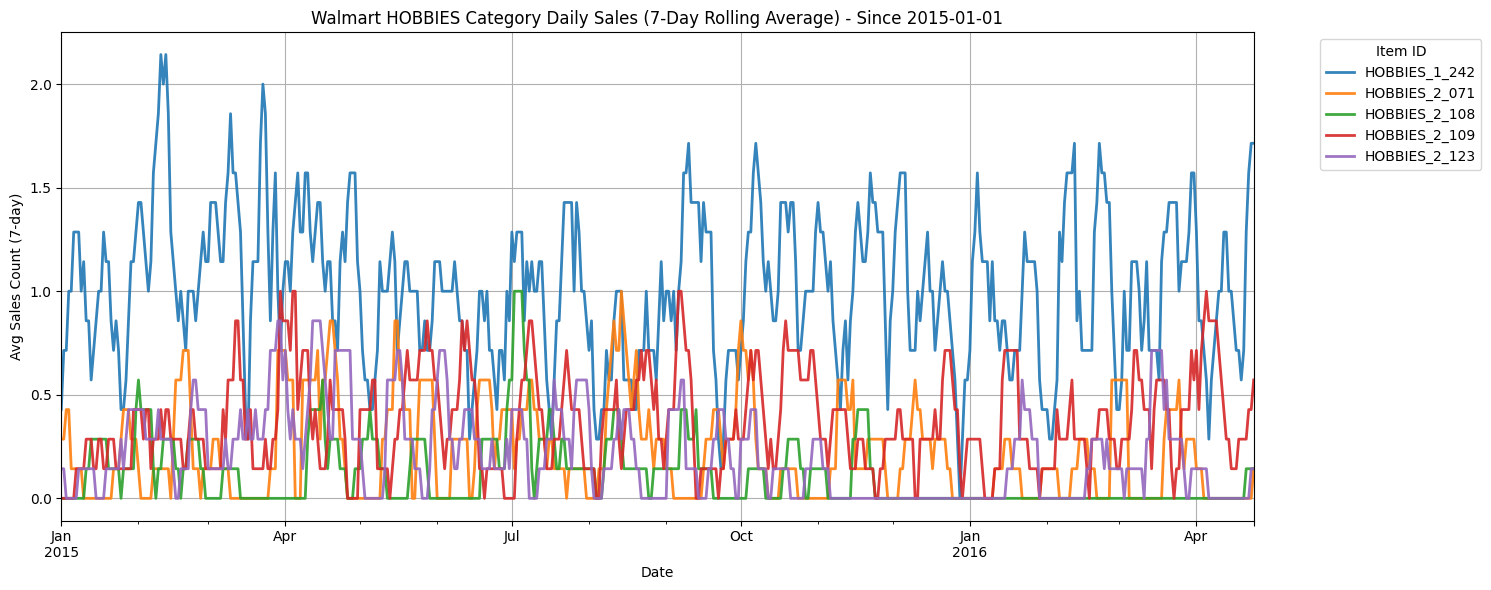


Data Verification:
Unique Days: 1913
Unique Items: 5
Expected Rows: 9565
Actual Rows: 9565
SUCCESS: Dataset is perfectly balanced (Panel Data) with strict daily frequency.
READY FOR MODELS: This Long Format (timestamp, unique_id, value, covariates) is ideal for:
 - Machine Learning (XGBoost, LightGBM) -> Features are columns, rows are samples.
 - Deep Learning (LSTM/Transformers) -> Can be reshaped to (Samples, Timesteps, Features).
 - Global Forecasting Models (Prophet, NeuralProphet) -> Often expect this stacked format.


In [56]:
# 6. Visualization and Frequency Check
# Raw daily sales for individual items are often sparse (0, 1, 0...), which makes a line chart look like vertical bars ("sloupce").
# To see the "curves" (trends), we will plot a 7-day rolling average.

# Configuration for Plotting
plot_start_date = '2015-01-01'  # Dynamic variable to filter the plot

# 1. Pivot for plotting (just for visualization!)
df_plot = df_final.reset_index()
df_wide = df_plot.pivot(index='timestamp', columns='unique_id', values='sales_count')

# 2. Enforce Daily Frequency and Fill NaNs
df_wide = df_wide.asfreq('D').fillna(0)

# 3. Calculate Rolling Average (7 days) to smooth the lines
df_rolling = df_wide.rolling(window=7).mean()

# 4. Filter by date
df_rolling_subset = df_rolling[df_rolling.index >= plot_start_date]

# 5. Plot
plt.figure(figsize=(15, 6))
df_rolling_subset.plot(ax=plt.gca(), linewidth=2, alpha=0.9)

plt.title(f'Walmart HOBBIES Category Daily Sales (7-Day Rolling Average) - Since {plot_start_date}')
plt.xlabel('Date')
plt.ylabel('Avg Sales Count (7-day)')
plt.legend(title='Item ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Verify Data Integrity for Models
# Confirm that the saved Long Format data covers all days for all items.
n_days = df_final.index.get_level_values('timestamp').nunique()
n_items = df_final.index.get_level_values('unique_id').nunique()
expected_rows = n_days * n_items
actual_rows = len(df_final)

print(f"\nData Verification:")
print(f"Unique Days: {n_days}")
print(f"Unique Items: {n_items}")
print(f"Expected Rows: {expected_rows}")
print(f"Actual Rows: {actual_rows}")
if expected_rows == actual_rows:
    print("SUCCESS: Dataset is perfectly balanced (Panel Data) with strict daily frequency.")
    print("READY FOR MODELS: This Long Format (timestamp, unique_id, value, covariates) is ideal for:")
    print(" - Machine Learning (XGBoost, LightGBM) -> Features are columns, rows are samples.")
    print(" - Deep Learning (LSTM/Transformers) -> Can be reshaped to (Samples, Timesteps, Features).")
    print(" - Global Forecasting Models (Prophet, NeuralProphet) -> Often expect this stacked format.")
else:
    print("WARNING: Dataset might have missing rows.")